# Anticipez les besoins en consommation électrique de bâtiments

- **Projet 4 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Nettoyage et analyse exploratoire des données

<img width="200" src="https://user.oc-static.com/upload/2019/02/24/15510245026714_Seattle_logo_landscape_blue-black.png" alt="Logo seattle">


# 1. Compréhension du problème

## 1.1 Mission

À partir des [relevés déjà réalisés en 2015 et 2016](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv) :

- **prédire les émissions de CO2** et la **consommation totale d’énergie** de bâtiments commerciales en Seattle pour lesquels elles n’ont pas encore été mesurées, basé sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction ...).

- **évaluer l’intérêt de l’[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what) pour la prédiction d’émissions**.


### 1.1.1 Quelles variables pour prédire les consommations / emissions CO2 ?

Il faut prédire les variables cibles uniquement avec les données disponibles sur le permis d'exploitation commerciale :

- on ne peut pas utiliser les relevés de consommation d'électricité, de gaz, etc comme paramètres des prévisions.
- on peut utiliser type d'usage, surface, nombre d'étages, moyenne de chauffage, ...


### 1.1.2 Quels bâtiments à inclure dans les prévisions ?

Il faut prédire les variables cibles uniquement pour les bâtiments commerciaux.

Donc, il faut éliminer la bias des bâtiments residential, si possible.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook

### 1.2.1 Import des bibliothèques


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno


### 1.2.2 Liste des versions des bibliothèques utilisées


In [2]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0


### 1.2.3 Configuration défauts d'affichage


In [3]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
# pd.set_option('display.precision', 2)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [4]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


def to_png(fig_name=None):
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(
            ':', '-').replace('.', '-').replace('/', '_')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [5]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


### 1.3.3 Fonctions divers


In [6]:
def round_digits(a_number, significant_digits=2):
    from math import floor, log10
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    return round(a_number, significant_digits - int(floor(log10(abs(a_number)))) - 1)


## 1.4 Des routines statistiques

Les routines statistiques utilisées dans ce notebook sont regroupés dans cette section :

- format des outputs
- normalité d'une série
- homoscédasticité de groupes pour une série


In [7]:
def format_stat_p(stat, p, name=None):
    ch = f'{name} : ' if name else ''
    ch += f'stat={stat:.3f}, p={p:.3f}'
    if p < 0.001:
        ch += '***'
    elif p < 0.01:
        ch += '**'
    elif p < 0.05:
        ch += '*'
    return ch


### 1.4.1 Des tests de normalité

- S'il y a moins de 50 observations, utilise Shapiro test,
- Sinon, utilise 'NormalTest' fourni par scipy qui est basé sur D’Agostino et Pearson.

Un alternatif est d'utiliser le test de Kolmogorov-Smirnov avec comparaison à la distribution normal ('goodness of fit')


In [8]:
from scipy.stats import shapiro, kstest


def test_normality(series: pd.Series, alpha=0.05):
    s = series.astype(float).dropna()
    if len(s) < 3:
        # il faut au moins 3 points
        return
    if len(s) < 50:
        stat, p = shapiro(s)
        ch = format_stat_p(stat, p, name=f'Shapiro [{s.name}]')
    else:
        stat, p = kstest(s, cdf='norm')
        ch = format_stat_p(stat, p, name=f'Kolmogorov-Smirnov [{s.name}]')
        # stat, p = normaltest(s)
        # ch = format_stat_p(stat, p, name=f'NormalTest [{s.name}]')
    if p > alpha:
        choix = 'accept H0: probablement Gaussian'
    else:
        choix = 'reject H0: probablement pas Gaussian'
    return p, ch, choix


### 1.4.2 Tests d'égalité de variance des groupes (homoscédasticité)

- si les groupes ont toutes une distribution normale, utilise Bartlett (test paramétrique)
- sinon, utilise Levene (test non paramétrique)


In [9]:
def group_by_groups(df: pd.DataFrame, y_var: str, groups_var: str) -> list:
    """Créer une liste de groupes de y_var pour tests statistiques entre groupes"""
    data = df[[y_var, groups_var]].dropna()
    # certain tests n'accepte pas type int
    data[y_var] = data[y_var].astype(float)
    groups = []
    group_names = data[groups_var].unique()
    group_names.sort()
    for group_name in group_names:
        groups.append(data[data[groups_var] == group_name]
                      [y_var].rename(group_name))
    return groups


def get_grp_size(groups: list) -> str:
    group_sizes = [len(g) for g in groups]
    return f'(n={np.sum(group_sizes)}), {group_sizes}'


In [10]:

from scipy.stats import bartlett, levene


def test_homoscedascity(groups: list, normality=False, alpha=0.05):
    print(f'test_homoscedascity groups : {get_grp_size(groups)}')
    if normality:
        stat, p = bartlett(*groups)
        ch = format_stat_p(stat, p, 'Bartlett homoscédasticité')
    else:
        stat, p = levene(*groups)
        ch = format_stat_p(stat, p, 'Levene homoscédasticité')
    if p > alpha:
        choix = 'accept H0: les groupes ont un écart type similaire'
    else:
        choix = 'reject H0: les groupes ont des écart types différents'
    return p, ch, choix


### 1.4.3 H-ANOVA (non paramétrique)


In [11]:
from scipy.stats import kruskal


def test_kruskal(groups: list, showsize=False):
    """Kruskal-Wallis H-test"""
    if showsize:
        print(f'{get_grp_size(groups)}')
    # compare samples (* = list comprehension)
    stat, p = kruskal(*groups)
    ch = format_stat_p(stat, p, 'Kruskal-Wallis H-test')
    alpha = 0.05
    if p > alpha:
        choix = 'accept H0: les médianes ne sont pas significativement différentes'
    else:
        choix = 'reject H0: les médianes sont significativement différentes'
    return p, ch, choix


### 1.4.4 Mann-Whitney U-test (non paramétrique)


In [12]:
def test_mannwhitneyu(group1: pd.Series, group2: pd.Series):
    """Mann-Whitney U-test entre group1 et group2, avec suppression de NaN
    et format de résultats
    """
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(group1.dropna(), group2.dropna())
    ch = f'Mann-Whitney U-test, {format_stat_p(stat, p)}'
    if p > 0.05:
        choix = 'accept H0: les médianes ne sont pas significativement différentes'
    else:
        choix = 'reject H0: les médianes sont significativement différentes'
    return p, ch, choix


test_mannwhitneyu(pd.Series([1, 2, 3, 4]),
                  pd.Series([10000, 20000, 30000, 40000]))


(0.02857142857142857,
 'Mann-Whitney U-test, stat=0.000, p=0.029*',
 'reject H0: les médianes sont significativement différentes')

# 2. Import et nettoyage des données

Les données de consommation sont à télécharger à [cette adresse](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv).


## 2.1 Description des données (metadata)

- les descriptions des champs sont fournies par les fichiers metadata (format json)
- conversion en CSV pour faciliter la lecture


In [13]:
import os
import json


def create_data_dict_csv_from_json(file: str, outfile: str) -> pd.DataFrame:
    if os.path.exists(outfile):
        return pd.read_csv(outfile).iloc[:, -3:]
    data = json.loads(open(file, "r").read())
    df = pd.json_normalize([data], record_path='columns', max_level=0)
    df = df[['name', 'dataTypeName', 'description']]
    df.to_csv(outfile)
    return df


meta2015 = 'data/raw/socrata_metadata_2015-building-energy-benchmarking.json'
meta2016 = 'data/raw/socrata_metadata_2016-building-energy-benchmarking.json'

if not os.path.exists('data/out'):
    os.makedirs('data/out')
out2015 = 'data/out/datadict2015.csv'
out2016 = 'data/out/datadict2016.csv'

dict2015 = create_data_dict_csv_from_json(meta2015, out2015)
dict2016 = create_data_dict_csv_from_json(meta2016, out2016)
print(f'2015 : il y a {len(dict2015)} colonnes')
print(f'2016 : il y a {len(dict2016)} colonnes')
print(sorted(set(dict2016['name'])))


2015 : il y a 47 colonnes
2016 : il y a 46 colonnes
['Address', 'BuildingType', 'City', 'Comments', 'ComplianceStatus', 'CouncilDistrictCode', 'DataYear', 'DefaultData', 'ENERGYSTARScore', 'Electricity(kBtu)', 'Electricity(kWh)', 'GHGEmissionsIntensity', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'Latitude', 'ListOfAllPropertyUseTypes', 'Longitude', 'NaturalGas(kBtu)', 'NaturalGas(therms)', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'OSEBuildingID', 'Outlier', 'PrimaryPropertyType', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal', 'PropertyName', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'State', 'SteamUse(kBtu)', 'TaxParcelIdentificationNumber', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'TotalGHGEmissions', 'YearBuilt', 'YearsENERGYSTARCertified', 'ZipCode']


### 2.1.1 Les variables cibles (targets) à prédire

En regardent les descriptions des champs (les fichiers CSV), on voit que les champs à prédire sont :

- `SiteEnergyUse(kBtu)` = **consommation totale d’énergie**
- `TotalGHGEmissions` = **les émissions de CO2 (equivalence)**

Ces 2 champs sont probablement fortement corrélés avec `PropertyGFABuilding(s)` = le surface totale intérieure du bâtiment : On attend qu'un gros bâtiment aura plus de consommation d'énergie qu'un petit bâtiment, pour la même type d'usage.

#### 2.1.1.1 Les variables alternatifs à prédire

Sans transformation des residues d'erreur, la modèle risque de mettre trop de poids pour les gros bâtiments. Une façon de réduire le poids des grands bâtiments sera de prédire :

- `SiteEUI(kBtu/sf)` = **consommation totale d’énergie** divisé par surface totale intérieure du bâtiment
- `GHGEmissionsIntensity` = **les émissions de CO2 (equivalence)** divisé par surface totale intérieure du bâtiment

Puis, multiplié ces previsions par la surface totale du bâtiment pour arriver à la prévision de consommation totale d'énergie.

On évaluera les effets pendant la modélisation


In [14]:
target_cols = ['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)',
               'TotalGHGEmissions', 'GHGEmissionsIntensity']

dict2016[dict2016['name'].isin(target_cols)]


,name,dataTypeName,description
29,SiteEUI(kBtu/sf),number,"Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot."
33,SiteEnergyUse(kBtu),number,The annual amount of energy consumed by the property from all sources of energy.
44,TotalGHGEmissions,text,"The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu."
45,GHGEmissionsIntensity,text,"Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources"


#### 2.1.1.2 Evaluation des champs associés ('Weather-Normalized') et 'SourceEUI'

Les données contiennent les champs de consommation, ajusté pour prendre en compte la météo ('Weather Normalized').

Si on utilise ces champs pour prédire la consommation énergétique on perd la variation causée par la météo, qu'on ne peut pas prévoir.

Ça peut réduire le bias causé par des années de météo exceptionnel.

Pourtant, l'objectif n'est pas de prédire la consommation énergétique ajustée à la météo des dernières 30 ans.

L'objectif n'est pas non plus d'inclure aussi les pertes d'énergie pendant transmission (sourceEUI)

Donc on ignore ces colonnes.


In [15]:
dict2016[dict2016['name'].str.contains('WN')]


,name,dataTypeName,description
30,SiteEUIWN(kBtu/sf),number,Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
32,SourceEUIWN(kBtu/sf),number,Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
34,SiteEnergyUseWN(kBtu),number,"The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions."


### 2.1.2 Les variables pertinentes pour prédire les variables cibles

Avant de nettoyer les données, il faut un model mental des possibles interactions

Regardent les métadonnées, les variables potentiellement intéressantes sont :

- La localisation du bâtiment (ilots de chaleur ?, effet de l'océan ?, effet de densité des bâtiments)
- Ses types d'usage et pourcentages pour chaque usage :
  - énergie = somme(%usage \* SiteEUI_par_type_usage)


In [16]:
cols_local = ['Address', 'City', 'CouncilDistrictCode',
              'Latitude', 'Longitude', 'Neighborhood', 'ZipCode']
cols_physique = ['NumberofBuildings', 'NumberofFloors',
                 'PropertyGFABuilding(s)', 'YearBuilt']
cols_surface = ['PropertyGFAParking', 'PropertyGFATotal']
cols_primary_usage = ['BuildingType', 'PrimaryPropertyType',
                      'LargestPropertyUseType', 'LargestPropertyUseTypeGFA']
cols_second_usage = ['SecondLargestPropertyUseType',
                     'SecondLargestPropertyUseTypeGFA']
cols_third_usage = ['ThirdLargestPropertyUseType',
                    'ThirdLargestPropertyUseTypeGFA']
cols_usage = ['LargestPropertyUseType']
cols_energy = ['ENERGYSTARScore']
cols_indisponible = ['Electricity(kBtu)', 'Electricity(kWh)', 'NaturalGas(kBtu)', 'NaturalGas(therms)',
                     'SteamUse(kBtu)']


### 2.1.3 Est-ce que les données de 2015 et 2016 sont compatibles ?


In [17]:
cols_commun = set(dict2015['name']).intersection(set(dict2016['name']))
cols_unique2015 = set(dict2015['name']).difference(set(dict2016['name']))
cols_unique2016 = set(dict2016['name']).difference(set(dict2015['name']))
print(f'Il y a {len(cols_commun)} colonnes commun aux données 2015 et 2016')
print(f'Colonnes unique à année 2015 : {sorted(cols_unique2015)}')
print(f'Colonnes unique à année 2016 : {sorted(cols_unique2016)}')


Il y a 37 colonnes commun aux données 2015 et 2016
Colonnes unique à année 2015 : ['2010 Census Tracts', 'City Council Districts', 'Comment', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Location', 'OtherFuelUse(kBtu)', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas', 'Zip Codes']
Colonnes unique à année 2016 : ['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude', 'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode']


### 2.1.4 Taches à faire pour pouvoir intégrer les 2 jeux de données

L'intégration des 2 jeux de données augmentera la taille du jeu de données, qui doit améliorer les capacités de prédiction. Pour le faire il faut :

1. Renommer quelque colonnes de 2015

| colonne en 2015                   | colonne en 2016       |
| --------------------------------- | --------------------- |
| GHGEmissions(MetricTonsCO2e)      | TotalGHGEmissions     |
| GHGEmissionsIntensity(kgCO2e/ft2) | GHGEmissionsIntensity |
| Zip Codes                         | ZipCode               |
| Comment                           | Comments              |

2. Voir si la colonne 'Location' de 2015 contient les champs de localisation utilisés en 2016 (Latitude, Longitude, Address, City, State), et faire l'extraction.

3. Évaluer l'utilité des colonnes présent seulement en 2015 ('2010 Census Tracts', 'City Council Districts', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas')

4. Vérifier que les 2 échantillons d'observations (2015, 2016) de consommation énergétique et emissions CO2 ne sont pas significativement différents

Si ont fait l'intégration des 2 années **avant nettoyage**, on va supposer qu'ils sont de la même population pour pouvoir les nettoyer ensemble.


## 2.2 Import des données

### 2.2.1 Import des données de 2015


In [18]:
def import_donnees(filename) -> pd.DataFrame:
    return pd.read_csv(filename, encoding='utf-8')


data2015 = import_donnees('data/raw/2015-building-energy-benchmarking.csv')
print(data2015.shape)
print(data2015.info(verbose=False))
data2015.head(3)


(3340, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Columns: 47 entries, OSEBuildingID to Zip Codes
dtypes: float64(23), int64(9), object(15)
memory usage: 1.2+ MB
None


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081


### 2.2.2 Import des données de 2016


In [19]:
data2016 = import_donnees('data/raw/2016-building-energy-benchmarking.csv')
print(data2016.shape)
print(data2016.info(verbose=False))
data2016.head(3)


(3376, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Columns: 46 entries, OSEBuildingID to GHGEmissionsIntensity
dtypes: bool(1), float64(22), int64(8), object(15)
memory usage: 1.2+ MB
None


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


### 2.2.3 Combien de bâtiments en commun entre 2015 et 2016

Les premiers 3 registres de 2015 et 2016 font référence aux mêmes bâtiments (clé = `OSEBuildingID`), même si le 'PropertyName' peut changer d'une année à l'autre.

- (2016 a 36 registres plus que 2015).


In [20]:
nb_bat_commun = len(
    data2015[data2015['OSEBuildingID'].isin(data2016['OSEBuildingID'])])
nb_bat_2015_seul = len(data2015) - nb_bat_commun
nb_bat_2016_seul = len(data2016) - nb_bat_commun

print(f'bâtiments commun à 2015 et 2016 : {nb_bat_commun}')
print(f'bâtiments 2015 seul : {nb_bat_2015_seul}')
print(f'bâtiments 2016 seul : {nb_bat_2016_seul}')


bâtiments commun à 2015 et 2016 : 3284
bâtiments 2015 seul : 56
bâtiments 2016 seul : 92


- Plus que 98% des bâtiments de 2015 sont dans le jeu de données 2016 (3284/3340)

- Plus que 97% des bâtiments de 2016 sont dans le jeu de données 2015 (3284/3376)

Verifier que l'identifiant 'OSEBuildingID' est la même bâtiment en 2015 et 2016 :


In [21]:
bat_communs = (pd.merge(
    left=data2015[['OSEBuildingID', 'PropertyName']],
    right=data2016[['OSEBuildingID', 'PropertyName']],
    how='inner', on='OSEBuildingID')
    .set_index('OSEBuildingID'))

bat_communs.tail()


,PropertyName_x,PropertyName_y
OSEBuildingID,,
50049,PACIFIC CENTER CONDOMINIUM,PACIFIC CENTER CONDOMINIUM (ID50049)
50055,IDENTITY APTS 4123,129610 - Identity Seattle Building D
50057,CIRRUS,Cirrus
50058,WEDGEWOOD ESTATES BLDG A,Wedgewood Estates Building A
50059,WEDGEWOOD ESTATES BLDG B,Wedgewood Estates Building B


### 2.2.4 Vérification qu'on peut fusionner les 2 tables


In [22]:
dtypes = pd.concat([data2015.dtypes.rename('2015'),
                    data2016.dtypes.rename('2016')], axis=1)
dtypes.T


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Address,City,State,ZipCode,Latitude,Longitude,Comments,TotalGHGEmissions,GHGEmissionsIntensity
2015,int64,int64,object,object,object,object,object,int64,object,int64,int64,float64,int64,int64,int64,object,object,float64,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,float64,float64,float64,float64,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,int64,int64,object,object,object,object,NaN,int64,object,int64,float64,int64,int64,int64,int64,object,object,float64,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,NaN,NaN,NaN,bool,NaN,object,object,NaN,NaN,NaN,NaN,NaN,object,object,object,float64,float64,float64,float64,float64,float64


On voit que certaines colonnes n'ont pas la même type pour en 2015 et 2016 :


In [23]:
# ignore les colonnes qui ne sont pas present en 2015 ou 2016
dtypes_different = dtypes[dtypes['2015'] != dtypes['2016']].dropna()
dtypes_different


,2015,2016
NumberofBuildings,int64,float64
NumberofFloors,float64,int64
DefaultData,object,bool


Les 'dtypes_different' entre des années ne pose pas un problème :

- Quand on fait la concatenation des 2 datasets, le nouveau dataset aura le dtype qui permet de prendre toutes les données sans erreur
- _note_ : dans la version de pandas utilisés ici, 'int64' et 'bool' n'accepte pas les valeurs 'np.NaN' : les colonnes sont converties en 'float64' et 'object' quand on ajoute les NaN


In [24]:
pd.concat([data2015, data2016], axis=0)[dtypes_different.index].dtypes


NumberofBuildings    float64
NumberofFloors       float64
DefaultData           object
dtype: object

## 2.3 Description de données (après import)

- Renommer target colonnes 2015 pour comparer avec 2016
- Description des variables à prédire (plus 'ENERGYStarScore')
- Description des variables numériques
- Description des variables catégoriques


### 2.3.1 Renommer target colonnes 2015 pour comparer avec 2016


In [25]:
def renommer_cols(df):
    df = df.rename(
        columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'})
    df = df.rename(
        columns={'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'})
    df = df.rename(columns={'Zip Codes': 'ZipCode'})
    df = df.rename(columns={'Comment': 'Comments'})
    return df


data2015 = data2015.pipe(renommer_cols)


### 2.3.2 Description des variables à prédire

#### 2.3.2.1 Est-ce que la consommation énergétique et emissions CO2 sont les mêmes pour 2015 et 2016 ?

Est-ce qu'on peut fusionner les 2 jeux de données sans ajuster les valeurs de consommation ?


In [26]:
print(data2015.shape)
print(data2016.shape)
data_df = pd.concat([data2015, data2016]).reset_index(drop=True)
print(data_df.shape)

data_df.pivot(columns='DataYear')[target_cols].describe()


(3340, 47)
(3376, 46)
(6716, 52)


SiteEnergyUse(kBtu)               SiteEUI(kBtu/sf)               \
DataYear                2015          2016             2015         2016   
count           3.330000e+03  3.371000e+03      3330.000000  3369.000000   
mean            4.983106e+06  5.403667e+06        53.626126    54.732116   
std             1.375330e+07  2.161063e+07        53.893311    56.273124   
min             0.000000e+00  0.000000e+00         0.000000     0.000000   
25%             9.139300e+05  9.251286e+05        27.300000    27.900000   
50%             1.776219e+06  1.803753e+06        37.400000    38.599998   
75%             4.044277e+06  4.222455e+06        59.875000    60.400002   
max             2.958126e+08  8.739237e+08       800.600000   834.400024   

         TotalGHGEmissions               GHGEmissionsIntensity               
DataYear              2015          2016                  2015         2016  
count          3330.000000   3367.000000           3330.000000  3367.000000  
mean            110.094102    119.723971              0.985339     1.175916  
std             409.450179    538.832227              1.637172     1.821452  
min               0.000000     -0.800000              0.000000    -0.020000  
25%               9.265000      9.495000              0.080000     0.210000  
50%              32.740000     33.920000              0.460000     0.610000  
75%              88.642500     93.940000              1.180000     1.370000  
max           11824.890000  16870.980000             31.380000    34.090000

##### Consommation énergétique des bâtiments en commun des 2 jeux de données a légèrement augmenté en 2016 par apport à 2015

On **_voit_** que la consommation énergétique en 2016 était en moyenne 2% plus qu'en 2015 (pas statistiquement significative). Il y a une multitude de possibles raisons :

- l'hiver 2016 était plus froid que 2015 (plus de chauffage)
- l'été 2016 était plus chaud que 2016 (plus de climatisation)
- les vents étaient plus forts en 2016
- l'activité commerciale était plus important en 2016
- les horaires de travail ont augmenté
- le cout d'énergie était plus bas
- les nouveaux bâtiments ajoutés en 2016 ont augmenté la moyenne

Il y a aussi plus de variation en consommation énergétique entre les bâtiments (l'écart type a augmenté par 1.6%)

- Il peut être dû à l'isolation de certains bâtiments

L'investigation de cause de ces augmentations est hors de portée de ce projet.


Les unités de mesure sont de la même ordre pour les 2 ans

- il faut tester les hypotheses qu'il n'y a pas des différences significatives entre les 2 ans pour pouvoir traiter les 2 ans comme un seul jeu de données
- on teste pour normalité pour choisir le test statistique (paramétrique t-test ou non paramétrique u-test)


#### 2.3.2.2 Est-ce que les variables à prédire, suivre des distributions normales ?


In [27]:
(pd.concat([
    data2015[target_cols].skew(),
    data2016[target_cols].skew()
], axis=1)
    .rename(columns={0: '2015', 1: '2016'}))


,2015,2016
SiteEnergyUse(kBtu),12.076222,24.841979
SiteEUI(kBtu/sf),4.704092,4.981886
TotalGHGEmissions,17.121821,19.481875
GHGEmissionsIntensity,5.302763,5.593145


Les distributions de consommation énergétique et emissions CO2 sont très asymétrique (skew > 4), donc ils ont clairement pas une distribution normale (skew=0).

Pour ENERGYSTARScore, le skew et moins fort, donc il faut tester statistiquement


In [28]:
test_normality(data2015['ENERGYSTARScore'])


(0.0,
 'Kolmogorov-Smirnov [ENERGYSTARScore] : stat=0.978, p=0.000***',
 'reject H0: probablement pas Gaussian')

#### 2.3.2.3 Test si les variables à prédire sont significativement different entre 2015 et 2016

Aucune des 'target' variables a une distribution normale

Donc, il faut utiliser des tests non paramétriques comme Mann-Whitney U-test


In [29]:
def test_variables_cibles(df2015, df2016, cols_cibles=None):
    if cols_cibles is None:
        cols_cibles = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
    for col in cols_cibles:
        group1 = df2015[col].dropna()
        group2 = df2016[col].dropna()
        if len(group1) > 0 and len(group2) > 0:
            p, ch, choix = test_mannwhitneyu(group1, group2)
            print(ch)
            if p > 0.05:
                print(
                    f'Accept H0: les moyennes de la colonne [{col}] pour 2015 et 2016 ne sont pas significativement différentes (p={p:.3f})')
            else:
                print(
                    f'Reject H0: les moyennes de la colonne [{col}] pour 2015 et 2016 sont significativement différentes (p={p:.3f})')


test_variables_cibles(data2015, data2016, cols_cibles=target_cols)


Mann-Whitney U-test, stat=5543971.000, p=0.385
Accept H0: les moyennes de la colonne [SiteEnergyUse(kBtu)] pour 2015 et 2016 ne sont pas significativement différentes (p=0.385)
Mann-Whitney U-test, stat=5498923.000, p=0.163
Accept H0: les moyennes de la colonne [SiteEUI(kBtu/sf)] pour 2015 et 2016 ne sont pas significativement différentes (p=0.163)
Mann-Whitney U-test, stat=5516762.000, p=0.259
Accept H0: les moyennes de la colonne [TotalGHGEmissions] pour 2015 et 2016 ne sont pas significativement différentes (p=0.259)
Mann-Whitney U-test, stat=4536446.500, p=0.000***
Reject H0: les moyennes de la colonne [GHGEmissionsIntensity] pour 2015 et 2016 sont significativement différentes (p=0.000)


#### 2.3.2.4 Conclusion : Les variables cibles à prédire ne sont pas significativement different entre 2015 et 2016

On peut fusionner les données de 2015 et 2016 sont ajustés les échelles entre chaque année.


### 2.3.3 Description de variables numériques


In [30]:
print(data_df.select_dtypes('number').columns)


Index(['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'ZipCode', 'Latitude',
       'Longitude'],
      dtype='object')


#### 2.3.3.1 Correction des datatypes catégoriques codés par des nombres

Des champs catégoriques basés sur codes numériques ont été importés comme float (s'il y a des valeurs manquantes) ou int (si aucune valeur manquante)

Il faut les corriger comme 'object' à fin qu'ils ne sont pas décrit comme variables numériques


In [31]:
def corriger_datatypes(df):
    """Assurer que les champs sont du bon type"""
    colonnes_a_corriger = ['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', '2010 Census Tracts',
                           'Seattle Police Department Micro Community Policing Plan Areas',
                           'City Council Districts', 'SPD Beats', 'ZipCode']
    df = df.copy()
    colonnes_a_corriger = cols_in_df(df, colonnes_a_corriger)
    for col in colonnes_a_corriger:
        df[col] = df[col].astype('object')

    # corriger zipcode (float --> str)
    if 'ZipCode' in df.columns:
        df['ZipCode'] = df['ZipCode'].fillna('').apply(
            lambda x: str(int(x)) if x else '')

    return df


data_df = data_df.pipe(corriger_datatypes)


#### 2.3.3.2 Description tabulaire (statistiques)


In [32]:
data_df.describe(include='number')


,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude
count,6716.000000,6708.000000,6708.000000,6.716000e+03,6716.000000,6.716000e+03,6.560000e+03,3238.000000,1156.000000,5093.000000,6699.000000,6700.000000,6697.000000,6697.000000,6.701000e+03,6.700000e+03,6.697000e+03,6.697000e+03,6.697000e+03,6.697000e+03,6.697000e+03,3.330000e+03,6697.000000,6697.000000,3376.000000,3376.000000
mean,1968.101549,1.071407,4.695736,9.281410e+04,9519.597975,8.329450e+04,7.707936e+04,28074.100153,11262.497750,67.906342,54.182341,57.308522,133.510303,138.356802,5.194673e+06,5.240110e+06,2.625076e+05,1.052458e+06,3.591058e+06,1.311223e+04,1.311223e+06,7.142301e+03,114.935638,1.081154,47.624033,-122.334795
std,33.020391,1.593505,5.476218,1.875062e+05,33868.050881,1.733470e+05,1.681617e+05,53473.984688,26287.655182,27.012124,55.101657,56.390651,135.677195,135.302508,1.813648e+07,1.500896e+07,3.704221e+06,3.659769e+06,1.248728e+07,5.685626e+04,5.685627e+06,1.962790e+05,478.876573,1.734763,0.047758,0.027203
min,1900.000000,0.000000,0.000000,1.128500e+04,-3.000000,-5.055000e+04,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,0.000000e+00,-0.800000,-0.020000,47.499170,-122.414250
25%,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.727300e+04,2.501600e+04,4993.000000,2325.000000,52.000000,27.600000,29.600000,74.000000,79.199997,9.200689e+05,9.818029e+05,0.000000e+00,1.867660e+05,6.372730e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.450000,0.160000,47.599860,-122.350662
50%,1974.000000,1.000000,4.000000,4.400800e+04,0.000000,4.218500e+04,3.953000e+04,10631.000000,5039.000000,75.000000,38.000000,40.900000,95.600000,102.099998,1.791071e+06,1.926136e+06,0.000000e+00,3.422434e+05,1.167735e+06,3.051000e+03,3.051000e+05,0.000000e+00,33.180000,0.540000,47.618675,-122.332495
75%,1996.000000,1.000000,5.000000,8.943125e+04,0.000000,8.112000e+04,7.417800e+04,26462.000000,10270.000000,90.000000,60.200000,64.925001,143.900000,149.800000,4.135280e+06,4.377974e+06,0.000000e+00,8.198140e+05,2.797320e+06,1.149639e+04,1.149639e+06,0.000000e+00,91.530000,1.280000,47.657115,-122.319407
max,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,8.269669e+06,16870.980000,34.090000,47.733870,-122.220966


### 2.3.4 Description de variables catégoriques


In [33]:
pd.set_option('display.max_rows', 30)
data_df.describe(exclude='number').T.sort_values(by='unique')


,count,unique,top,freq
State,3376,1,WA,3376
City,3376,1,Seattle,3376
DataYear,6716,2,2016,3376
City Council Districts,213,2,1,139
Outlier,116,4,High Outlier,46
DefaultData,6715,4,False,3263
ComplianceStatus,6716,5,Compliant,6548
CouncilDistrictCode,6716,7,7,2074
BuildingType,6716,8,NonResidential,2921
2010 Census Tracts,224,13,123,48


On peut éliminer variables: city(toujours 'Seattle') et state(toujours 'WA')


#### 2.3.4.1 Catégories de 'ComplianceStatus'


In [34]:
data_df['ComplianceStatus'].value_counts()


Compliant                       6548
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Not Compliant                      3
Name: ComplianceStatus, dtype: int64

#### 2.3.4.2 BuildingType


In [35]:
data_df['BuildingType'].value_counts(normalize=True) * 100


NonResidential          43.493151
Multifamily LR (1-4)    30.479452
Multifamily MR (5-9)    16.885051
Multifamily HR (10+)     3.231090
SPS-District K-12        2.933294
Nonresidential COS       2.278142
Campus                   0.684932
Nonresidential WA        0.014890
Name: BuildingType, dtype: float64

Plus que 50% des bâtiments sont résidentiels ('multifamily')


#### 2.3.4.3 PrimaryPropertyType

Il y a des erreurs de whitespace

- on suppose qu'il peut avoir dans les autres catégories de PropertyType


In [36]:
data_df['PrimaryPropertyType'].value_counts()


Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- and Mid-Sized Office     590
Other                           514
Large Office                    344
                               ... 
Restaurant                       13
Laboratory                       11
Restaurant\n                     11
SPS-District K-12                 4
Office                            3
Name: PrimaryPropertyType, Length: 32, dtype: int64

In [37]:
','.join(sorted(list(data_df['PrimaryPropertyType'].unique())))


'College/University,Distribution Center,Distribution Center\n,High-Rise Multifamily,Hospital,Hotel,K-12 School,Laboratory,Large Office,Low-Rise Multifamily,Medical Office,Mid-Rise Multifamily,Mixed Use Property,Non-Refrigerated Warehouse,Office,Other,Refrigerated Warehouse,Residence Hall,Residence Hall/Dormitory,Restaurant,Restaurant\n,Retail Store,SPS-District K-12,Self-Storage Facility,Self-Storage Facility\n,Senior Care Community,Small- and Mid-Sized Office,Supermarket / Grocery Store,Supermarket/Grocery Store,University,Warehouse,Worship Facility'

#### 2.3.4.4 LargestPropertyUseType

Très similaire à PrimaryPropertyType


In [38]:
data_df[['LargestPropertyUseType', 'PrimaryPropertyType']].value_counts().head(10)


LargestPropertyUseType      PrimaryPropertyType        
Multifamily Housing         Low-Rise Multifamily           1929
                            Mid-Rise Multifamily           1084
Office                      Small- and Mid-Sized Office     575
                            Large Office                    338
K-12 School                 K-12 School                     275
Multifamily Housing         High-Rise Multifamily           200
Non-Refrigerated Warehouse  Warehouse                       187
Other                       Other                           187
Non-Refrigerated Warehouse  Non-Refrigerated Warehouse      182
Retail Store                Retail Store                    180
dtype: int64

#### 2.3.4.5 ListOfAllPropertyUseTypes

La plupart d'usages sont residential et parking.
Il faut réduire leur impact sur la modélisation


In [39]:
data_df['ListOfAllPropertyUseTypes'].str.split(
    ',').explode().str.strip().value_counts()[:10]


Multifamily Housing           3339
Parking                       2079
Office                        1685
Retail Store                   802
Non-Refrigerated Warehouse     518
Other                          505
Restaurant                     310
K-12 School                    291
Medical Office                 157
Hotel                          155
Name: ListOfAllPropertyUseTypes, dtype: int64

## 2.4 Nettoyage des données

- importer données 2015
- renommer cols (GHGEmissions, GHGEmissionsIntensity,...)
- convertir 'Location' en champs 'Latitude','Longitude', 'Address', ...
- ajouter les données 2016 aux données 2015
- exclure bâtiments pour lesquels ont n'a seulement une année de données
- corriger les catégories 'PropertyType', 'LargestUseType'
  - enlever whitespace ('\n')
- corriger 'Neighborhood' pour être les mêmes pour 2015 et 2016
- éliminer bâtiments residential sans utilisation commerciale
- éliminer bâtiments 'non-compliant' (manque de données)
- excluire bâtiments avec des grosses variations de consommation entre 2015 et 2016


In [40]:
data2015 = import_donnees('data/raw/2015-building-energy-benchmarking.csv')
data2015 = data2015.pipe(renommer_cols)


### 2.4.1 Convertir Location en (Latitude, Longitude, Address, ZipCode)

Pas besoin d'extraire city (toujours 'SEATTLE') et state (toujours 'WA')


In [41]:
data2015['Location'][0]


'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [42]:
def split_location(df):
    """
    Extraire (lat, lon, address, zip, city, state) du champ 'Location' en format json non-standard
    {'latitude':'47.61219025','longitude':'-122.33799744',
    'human_address':'{"address":"405 OLIVE WAY","city":"SEATTLE","state":"WA","zip":"98101"}'}
    """
    if 'Location' not in df.columns:
        return df
    df = df.copy()
    # corrigé le json non-standard du champ 'Location', puis convertir
    df['Location'] = (df['Location']
                      .str.replace("\'", "\"")
                      .str.replace('"{"', '{"')
                      .str.replace('}"}', '} }'))
    (df['Latitude'], df['Longitude'], df['Address'],
     df['ZipCode'], df['City'], df['State']) = zip(
        *df['Location']
        .apply(json.loads)
        .apply(lambda x: (float(x['latitude']),
                          float(x['longitude']),
                          str(x['human_address']['address']),
                          str(int(x['human_address']['zip'])),
                          str(x['human_address']['city']),
                          str(x['human_address']['state']),
                          ))
    )
    df['ZipCode'] = df['ZipCode'].astype(str)
    df = df.drop(columns={'Location'})  # plus besoin
    return df


data2015 = data2015.pipe(split_location)
data2015.head()


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,ZipCode,Latitude,Longitude,Address,City,State
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,98101,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,98101,47.613106,-122.333358,724 PINE ST,SEATTLE,WA
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,98101,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,98101,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,98121,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA


### 2.4.2 Concaténer les deux tables 2015 et 2016

Si on prend la moyenne de 2015 et 2016, ça va réduire la bias de 2015, mais peut augmenter le sur apprentissage, car on perd l'information sur les possibles variations d'une année à l'autre.

Donc on ajoute des données de 2015 et 2016, et supprime-les 2% des bâtiments avec seulement une année de données.


In [43]:
def append_donnees_2016(df_2015, df_2016):
    """Ajouter données de l'année 2016"""
    return df_2015.append(df_2016).reset_index(drop=True)


data2016 = import_donnees('data/raw/2016-building-energy-benchmarking.csv')

data_df = data2015.pipe(append_donnees_2016, data2016)
print(data_df.shape)


(6716, 51)


### 2.4.3 Corriger les types des données

Plusieurs colonnes catégoriques ont été importées comme numérique.

On corrige leur datatype


In [44]:
data_df = data_df.pipe(corriger_datatypes)


### 2.4.4 Analyser les bâtiments pour lequel ont n'a seulement une année de données

#### 2.4.4.1 Les 56 bâtiments pour lequel il y a des données seulement pour 2015 :


In [45]:
data_2015_seul = data2015[~data2015['OSEBuildingID'].isin(
    bat_communs.index)]
data_2015_both = data2015[data2015['OSEBuildingID'].isin(
    bat_communs.index)]

print(
    f'bâtiments 2015 et 2016 - année construite (moyenne) : {round(data_2015_both["YearBuilt"].mean())}')
print(
    f'bâtiments 2015 seul - année construite (moyenne): {round(data_2015_seul["YearBuilt"].mean())}')
print(
    f'bâtiments 2015 et 2016 : médiane consommation énergétique/sf = {data_2015_both["SiteEUI(kBtu/sf)"].median():.2f}')
print(
    f'bâtiments 2015 seul : médiane consommation énergétique/sf = {data_2015_seul["SiteEUI(kBtu/sf)"].median():.2f}')


bâtiments 2015 et 2016 - année construite (moyenne) : 1968
bâtiments 2015 seul - année construite (moyenne): 1956
bâtiments 2015 et 2016 : médiane consommation énergétique/sf = 37.50
bâtiments 2015 seul : médiane consommation énergétique/sf = 30.30


Les bâtiments present seulement en 2015 se sont en general des vieux bâtiments, avec une consommation par surface plus bas que les bâtiments present aussi en 2016.

- Peut-être la raison qu'il n'y a pas des données pour 2016, c'est parce qu'ils étaient démolis / en travaux pendant 2016.
- Si c'est le cas, leur consommation énergétique ne seraient pas representative de leur consommation annuelle
- il faut les exclure sauf si on trouve d'autre explication pour ces différences


In [46]:
test_mannwhitneyu(data_2015_seul['SiteEUI(kBtu/sf)'],
                  data_2015_both['SiteEUI(kBtu/sf)'])


(0.07558503000672796,
 'Mann-Whitney U-test, stat=77497.500, p=0.076',
 'accept H0: les médianes ne sont pas significativement différentes')

In [47]:
cols = ['PropertyName', 'YearBuilt',
        'BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes']
cols.extend(target_cols)
data_2015_seul[cols].sort_values(by='SiteEUI(kBtu/sf)').head()


,PropertyName,YearBuilt,BuildingType,PrimaryPropertyType,ListOfAllPropertyUseTypes,SiteEnergyUse(kBtu),SiteEUI(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
1522,BRIGHTON PRESBYTERIAN CHURCH,1927,NonResidential,Worship Facility,NaN,91996.0,4.2,0.64,0.01
702,1916 Boren Building,1929,NonResidential,Small- and Mid-Sized Office,Office,133880.0,6.2,0.93,0.02
2055,BRISTOL APARTMENTS,1908,Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,194839.0,8.7,1.38,0.02
2466,FISHER BUILDING,1900,NonResidential,Retail Store,NaN,184077.0,9.0,1.28,0.02
1305,EITEL BUILDING (2ND AND PIKE BUILDING),1904,NonResidential,Other,"Other, Personal Services (Health/Beauty, Dry Cleaning, etc), Restaurant, Retail Store",413919.0,9.2,4.43,0.06


#### 2.4.4.2 Les 92 bâtiments pour lequel il y a des données seulement en 2016 :


In [48]:
data_2016_seul = data2016[~data2016['OSEBuildingID'].isin(bat_communs.index)]
data_2016_both = data2016[data2016['OSEBuildingID'].isin(bat_communs.index)]

data_2016_seul['YearBuilt'].value_counts()[:2]


2015    35
2014    16
Name: YearBuilt, dtype: int64

Plus que 51 des 92 bâtiments en 2016 sont des nouveaux bâtiments.

On demande si leur consommation énergétique en 2016 est representative de leur consommation annuelle :

- peut-être ils n'étaient pas encore occupés à 100% pour l'année 2016, ou ils avaient encore des travaux en cours.
- Il faut comparer leur consommation avec d'autres propriétés de la même âge et usages, avant de les inclure dans les jeux de données d'entrainement / test
- il faut les exclure, sauf si on trouve d'autre explication pour ces différences


In [49]:
print(
    f"bâtiments 2016 seul : moyenne consommation énergétique/sf = {data_2016_seul['SiteEUI(kBtu/sf)'].mean():.2f}")
print(
    f"bâtiments 2016 both : moyenne consommation énergétique/sf = {data_2016_both['SiteEUI(kBtu/sf)'].mean():.2f}")
# test_mannwhitneyu(data_2016_seul['SiteEUI(kBtu/sf)'],data_2016_both['SiteEUI(kBtu/sf)'])
test_mannwhitneyu(data_2016_seul['GHGEmissionsIntensity'],
                  data_2016_both['GHGEmissionsIntensity'])


bâtiments 2016 seul : moyenne consommation énergétique/sf = 74.09
bâtiments 2016 both : moyenne consommation énergétique/sf = 54.19


(0.002464625260722248,
 'Mann-Whitney U-test, stat=175009.500, p=0.002**',
 'reject H0: les médianes sont significativement différentes')

In [50]:
print(
    f'SiteEUI(kBtu/sf) médiane = {data2016["SiteEUI(kBtu/sf)"].median():.2f}')
print(
    f'GHGEmissionsIntensity médiane = {data2016["GHGEmissionsIntensity"].median():.2f}')
data_2016_seul.sort_values(by='SiteEUI(kBtu/sf)', ascending=False).head()


SiteEUI(kBtu/sf) médiane = 38.60
GHGEmissionsIntensity médiane = 0.61


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
240,365,2016,NonResidential,Other,UW Tower Data Center,4333 BROOKLYN AVE NE,Seattle,WA,98185.0,1142000290,4,NORTHEAST,47.66060,-122.31512,1969,1.0,5,36000,0,36000,Data Center,Data Center,36000.0,NaN,NaN,NaN,NaN,2016201520142013,96.0,834.400024,834.400024,2620.000000,2620.000000,30038490.0,30038490.0,0.0,8.803777e+06,3.003849e+07,0.00000,0.000,False,NaN,Compliant,NaN,209.41,5.82
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5765898.0,6053764.5,0.0,5.252517e+05,1.792159e+06,39737.39063,3973739.063,False,NaN,Compliant,NaN,223.54,16.99
3365,50208,2016,Nonresidential COS,Other,Ballard Pool,1471 NW 67th St,Seattle,WA,NaN,3050700005,6,BALLARD,47.67734,-122.37624,1972,1.0,1,12769,0,12769,"Fitness Center/Health Club/Gym, Office, Other - Recreation, Swimming Pool",Other - Recreation,10912.0,Fitness Center/Health Club/Gym,1670.0,Office,187.0,NaN,NaN,400.799988,420.600006,618.099976,638.900024,5117308.5,5370263.5,0.0,3.532161e+05,1.205173e+06,39121.35156,3912135.156,False,NaN,Compliant,NaN,216.18,16.93
3367,50212,2016,Nonresidential COS,Other,Conservatory Campus,1400 E Galer St,Seattle,WA,NaN,2925049087,3,EAST,47.63228,-122.31574,1912,1.0,1,23445,0,23445,Other - Recreation,Other - Recreation,23445.0,NaN,NaN,NaN,NaN,NaN,NaN,254.899994,286.500000,380.100006,413.200012,5976246.0,6716330.0,0.0,3.695398e+05,1.260870e+06,47153.75781,4715375.781,False,NaN,Compliant,NaN,259.22,11.06
3277,49972,2016,NonResidential,University,Computer Science and Electrical Engineering,3785 E Stevens Way NE,Seattle,WA,98195.0,1625049001,4,NORTHEAST,47.65356,-122.30613,1998,1.0,6,203030,0,203030,College/University,College/University,203030.0,NaN,NaN,NaN,NaN,NaN,NaN,252.000000,0.000000,561.000000,0.000000,51168308.0,0.0,0.0,8.386464e+06,2.861461e+07,0.00000,0.000,False,NaN,Compliant,NaN,199.48,0.98


Les bâtiments present seulement en 2016 ne sont pas representative des bâtiments :

- les datacenter ont les consommations énergétiques par surface 20 fois plus grand que la médiane
- les piscines / campus qui utilise plus de gaz natural (chauffage) que d'électricité ont les émissions CO2 par surface 27 fois plus grand que la médiane

Si on supprime les data center, on perd la capacité de prévoir leur consommation.

Idem pour les piscines

Néanmoins, il est preferable d'avoir confirmation des consommations annuelles (par comparaison avec 2015), que garder un seul point sans pouvoir être sûr que c'est representative de la consommation annuelle, ou seulement une partie de l'année.


##### Sommaire :

Les 2% des batiments qui n'ont pas des données pour comparer entre années sont problematique:

Les 56 bâtiments qui sont seulement en 2015 sont beaucoup plus vieux que
la population (démolis ou en reforme en 2016 ?) → on les supprime

Les 92 bâtiments present seulement en 2016 sont pour la plupart des nouveaux bâtiments (encore en construction / partiellement remplie ?) → on les supprime.


#### 2.4.4.3 Re-tester après exclusion des bâtiments avec seulement 1 an de données


In [51]:
test_mannwhitneyu(data_2015_both['GHGEmissionsIntensity'],
                  data_2016_both['GHGEmissionsIntensity'])


(7.357927007024667e-39,
 'Mann-Whitney U-test, stat=4367990.500, p=0.000***',
 'reject H0: les médianes sont significativement différentes')

##### Éliminer les données présent dans une seule année


In [52]:

def drop_buildings_one_data_measurement(df):
    """Exclure bâtiments pour lesquels ont n'a seulement une année de données"""
    df = df.copy()
    df['DataYear'] = df['DataYear'].astype(str)
    df2015 = df[df['DataYear'] == '2015']
    df2016 = df[df['DataYear'] == '2016']
    buildings_in_both = df2015[df2015['OSEBuildingID'].isin(
        df2016['OSEBuildingID'])]
    print(f'bâtiments en commun {len(buildings_in_both)}')
    return df[df['OSEBuildingID'].isin(buildings_in_both['OSEBuildingID'])]


print(data_df.shape)
data_df = data_df.pipe(drop_buildings_one_data_measurement)
print(data_df.shape)


(6716, 51)
bâtiments en commun 3284
(6568, 51)


### 2.4.5 Éliminer lignes sans données pour les variables cibles

Sans données de consommation énergétique, on ne peut pas utiliser les données


In [53]:
def drop_lignes_sans_cible(df):
    df = df.copy()
    print(f'drop_lignes_sans_cible: {sorted(set(target_cols))}')
    for col in target_cols:
        filtre = df[df[col].isna()]
        nb = filtre[col].sum()
        if nb > 0:
            print(f'drop {nb} lignes sans données pour cible [{col}]')
            df = df[~filtre]
    return df


data_df = data_df.pipe(drop_lignes_sans_cible)


drop_lignes_sans_cible: ['GHGEmissionsIntensity', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']


### 2.4.6 Corriger les 'PropertyUseType'

Les champs de 'UseType' contiennent parfois des caractères 'whitespace'. On le supprime


In [54]:
def corriger_property_use_type(df):
    """Supprime 'whitespace' dans les colonnes de 'PrimaryUseType'"""
    cols_to_trim = ['PrimaryPropertyType', 'LargestPropertyUseType',
                    'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
                    'ListOfAllPropertyUseTypes']
    df = df.copy()
    for col in cols_to_trim:
        df[col] = df[col].str.replace(
            '\n', '').str.replace(' / ', '/').str.strip()
    return df


data_df = data_df.pipe(corriger_property_use_type)
print(data_df.shape)


(6568, 51)


### 2.4.7 Elimination des bâtiments non-commerciales

- L'équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.
- Est-ce que les données sont tous non-residential ?


In [55]:
data_df['BuildingType'].value_counts()


NonResidential          2867
Multifamily LR (1-4)    2014
Multifamily MR (5-9)    1099
Multifamily HR (10+)     214
SPS-District K-12        196
Nonresidential COS       135
Campus                    43
Name: BuildingType, dtype: int64

In [56]:
data_df['PrimaryPropertyType'].value_counts().head()


Low-Rise Multifamily           1953
Mid-Rise Multifamily           1070
Small- and Mid-Sized Office     581
Other                           494
Large Office                    335
Name: PrimaryPropertyType, dtype: int64

Il y a des différences de definition multifamily entre BuildingType et PrimaryPropertyType

Avant d'éliminer les bâtiments "multifamily, on vérifie que leur PrimaryPropertyType==residential

- Est-ce qu'on peut les bien séparés ?
- Sinon, est-ce qu'on peut éliminer les bâtiments qui n'a aucune utilisation commerciale ?


In [57]:
residential = data_df[data_df['BuildingType'].str.contains('family')]
residential[['BuildingType', 'LargestPropertyUseType',
             'PrimaryPropertyType']].value_counts()


BuildingType          LargestPropertyUseType       PrimaryPropertyType        
Multifamily LR (1-4)  Multifamily Housing          Low-Rise Multifamily           1904
Multifamily MR (5-9)  Multifamily Housing          Mid-Rise Multifamily           1050
Multifamily HR (10+)  Multifamily Housing          High-Rise Multifamily           197
Multifamily LR (1-4)  Senior Care Community        Senior Care Community            28
                      Multifamily Housing          Mixed Use Property               20
Multifamily MR (5-9)  Multifamily Housing          Mixed Use Property               14
                      Senior Care Community        Senior Care Community            12
Multifamily HR (10+)  Senior Care Community        Senior Care Community             6
Multifamily LR (1-4)  Other                        Other                             6
Multifamily HR (10+)  Other                        Other                             2
Multifamily LR (1-4)  Office                       

Est-ce qu'on perd des données sur le deuxième usage de la propriété ?


In [58]:
residential['SecondLargestPropertyUseType'].value_counts().head(10)


Parking                       1175
Retail Store                   134
Office                          90
Other                           29
Restaurant                      23
Swimming Pool                   11
Multifamily Housing             10
Supermarket/Grocery Store        8
Non-Refrigerated Warehouse       6
Food Service                     6
Name: SecondLargestPropertyUseType, dtype: int64

La majorité de deuxième usage et du parking, qui ne doit pas avoir un grand impact sur la consommation énergétique.

Pour les autres types d'usage, on ne sait pas quelle portion de la consommation électrique est residential, et quelle portion est commerciale, donc on risque d'introduire un 'non-commercial biais' sur ces types d'usage

On peut supprimer les bâtiments du type 'multifamily'


In [59]:
def drop_residential(df):
    df = df.copy()
    df = df[~df['BuildingType'].str.contains('family')]
    return df


data_df = data_df.pipe(drop_residential)
print(data_df.shape)


(3241, 51)


In [60]:
data_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 6661
Columns: 51 entries, OSEBuildingID to State
dtypes: float64(22), int64(4), object(25)
memory usage: 1.3+ MB


In [61]:
data_df.select_dtypes(exclude=np.number).nunique().sort_values().head()


State                     1
City                      2
City Council Districts    2
DataYear                  2
ComplianceStatus          4
dtype: int64

### 2.4.8 Éliminer les bâtiments avec des données 'non-compliant'

Les données qui sont indiqués comme 'outlier' sont aussi marqués :
ComplianceStatus == (Non-Compliant) ou (Error - Correct Default Data)

Donc, filtre les registres ou ComplianceStatus est un de:
Missing Data, Error - Correct Default Data, Non-Compliant

- éliminer bâtiments 'non-compliant' (manque de données)
- exclure colonnes non pertinentes
- exclure colonnes avec données manquantes
- exclure colonnes pour lesquelles on n'aura pas de données pour prévoir consommation énergétique
  (consommation électrique, gaz, ...)


In [62]:
data_df['ComplianceStatus'].value_counts()


Compliant                       3124
Error - Correct Default Data      85
Non-Compliant                     18
Missing Data                      14
Name: ComplianceStatus, dtype: int64

In [63]:
def drop_non_compliant(df):
    df = df[df['ComplianceStatus'] == 'Compliant']
    return df


print(data_df.shape)
data_df = data_df.pipe(drop_non_compliant)
print(data_df.shape)


(3241, 51)
(3124, 51)


### 2.4.9 Elimination des outliers

- bâtiments ou la consommation énergétique a changé beaucoup d'une année à une autre
- Qu'est-ce c'est beaucoup ?


In [64]:
energy_use = (data_df
              .pivot(index=['OSEBuildingID', 'PrimaryPropertyType'], columns='DataYear', values=['SiteEnergyUse(kBtu)'])
              .droplevel(0, axis=1)
              .reset_index().set_index('OSEBuildingID')
              .dropna()
              )
energy_use['variation'] = 100 * (energy_use['2016'] / energy_use['2015'] - 1)
energy_use.describe()


DataYear,2015,2016,variation
count,1.250000e+03,1.250000e+03,1250.000000
mean,8.549303e+06,8.650514e+06,inf
std,2.033878e+07,2.061284e+07,NaN
min,0.000000e+00,5.713320e+04,-75.930756
25%,1.381795e+06,1.373540e+06,-4.484949
50%,2.978649e+06,3.034032e+06,0.537275
75%,7.796716e+06,8.125698e+06,5.951133
max,2.958126e+08,2.930908e+08,inf


<AxesSubplot:xlabel='variation'>

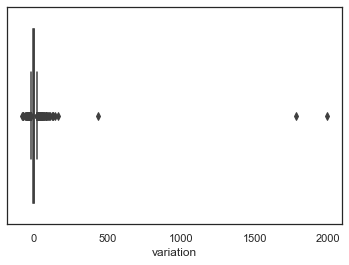

In [65]:
sns.boxplot(x=energy_use['variation'])


In [66]:
energy_use_outliers = energy_use['variation'] > 300
print(energy_use[energy_use_outliers])


DataYear               PrimaryPropertyType       2015          2016  \
OSEBuildingID                                                         
765                           Large Office        0.0  1.624611e+07   
803            Small- and Mid-Sized Office  2019254.0  3.795171e+07   
24205                                Other   293217.0  6.129780e+06   
26849                         Retail Store   181491.0  9.772303e+05   

DataYear         variation  
OSEBuildingID               
765                    inf  
803            1779.491535  
24205          1990.526811  
26849           438.445605  


Bâtiment avec OSEBuildingID=803 montre 2000% variation en consommation énergétique.

Pour calculer le moyenne et écart de variation, il faut d'abord supprimer ces tres grosses variations


In [67]:
energy_use = energy_use[~energy_use_outliers]
energy_use.describe()


DataYear,2015,2016,variation
count,1.246000e+03,1.246000e+03,1246.000000
mean,8.574747e+06,8.629083e+06,1.968158
std,2.036640e+07,2.062681e+07,18.151941
min,5.340100e+04,5.713320e+04,-75.930756
25%,1.387761e+06,1.373540e+06,-4.499976
50%,2.998007e+06,3.023934e+06,0.514044
75%,7.829348e+06,8.078791e+06,5.922099
max,2.958126e+08,2.930908e+08,167.097447


Text(0.5, 0, 'variation de consommation énergétique entre 2015 et 2016 (%)')

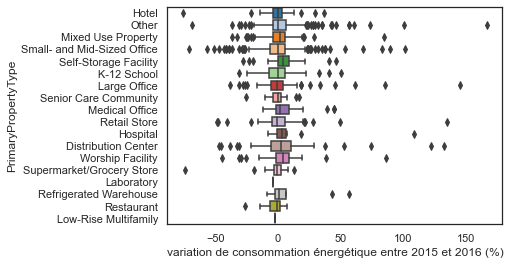

In [68]:
sns.boxplot(data=energy_use, y='PrimaryPropertyType', x='variation')
plt.xlabel('variation de consommation énergétique entre 2015 et 2016 (%)')


Text(0.5, 8.95999999999998, 'variation de SiteEnergyUse (%)')

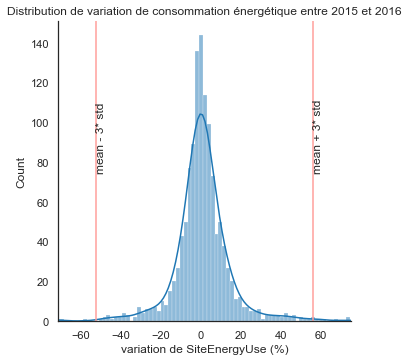

In [69]:
def plot_series_distribution(series: pd.Series, show_thresholds=False):
    sns.displot(x=series, alpha=0.5, kde=True)
    x_min = round_digits(series.mean() - 4 * series.std())
    x_max = round_digits(series.mean() + 4 * series.std())
    plt.xlim((x_min, x_max))

    if show_thresholds:
        y_min, y_max = plt.ylim()
        y_text = (y_max + y_min) / 2
        min_threshold = series.mean() - series.std() * 3
        plt.axvline(x=min_threshold, color='r')
        plt.text(x=min_threshold, y=y_text, s='mean - 3* std', rotation=90)

        max_threshold = series.mean() + series.std() * 3
        plt.axvline(x=max_threshold, color='r')
        plt.text(x=max_threshold, y=y_text, s='mean + 3* std', rotation=90)


plot_series_distribution(energy_use['variation'], show_thresholds=True)
plt.title('Distribution de variation de consommation énergétique entre 2015 et 2016')
plt.xlabel('variation de SiteEnergyUse (%)')


In [70]:
print(energy_use['variation'].mean())
print(energy_use['variation'].std())
print(energy_use['variation'].kurtosis())
test_normality(energy_use['variation'])


1.9681578641882764
18.151940647989047
19.40905720740183


(2.5441996705161146e-183,
 'Kolmogorov-Smirnov [variation] : stat=0.403, p=0.000***',
 'reject H0: probablement pas Gaussian')

En effet, la distribution des variations est plus étroite qu'une distribution normale.

On supprime les bâtiments ou la variation de SiteEnergyUse est plus de 60% entre 2015 et 2016


In [71]:
def drop_outliers_variation_consommation(df):
    site_energy_use = (df.pivot(index='OSEBuildingID', columns='DataYear', values='SiteEnergyUse(kBtu)')
                       .dropna())
    site_energy_use['variation'] = 100 * \
        (site_energy_use['2016'] / site_energy_use['2015'] - 1)
    # filtre : variation > 80% entre 2015 et 2016
    # environ 4 écarts types
    variation_outliers = abs(site_energy_use['variation']) > 80
    building_outliers = site_energy_use[variation_outliers].index
    print(f'éliminer outliers variation_consommation :{building_outliers}')
    df = df.set_index('OSEBuildingID').drop(building_outliers).reset_index()
    return df


data_df = data_df.pipe(drop_outliers_variation_consommation)


éliminer outliers variation_consommation :Int64Index([   58,   355,   543,   580,   765,   803, 20402, 20871, 21119,
            23701, 23730, 23835, 24102, 24205, 24531, 26710, 26849, 27184,
            27381, 27668, 28033, 34348, 49940],
           dtype='int64', name='OSEBuildingID')


### 2.4.98 Analyse de la distribution de valeurs manquantes


<AxesSubplot:>

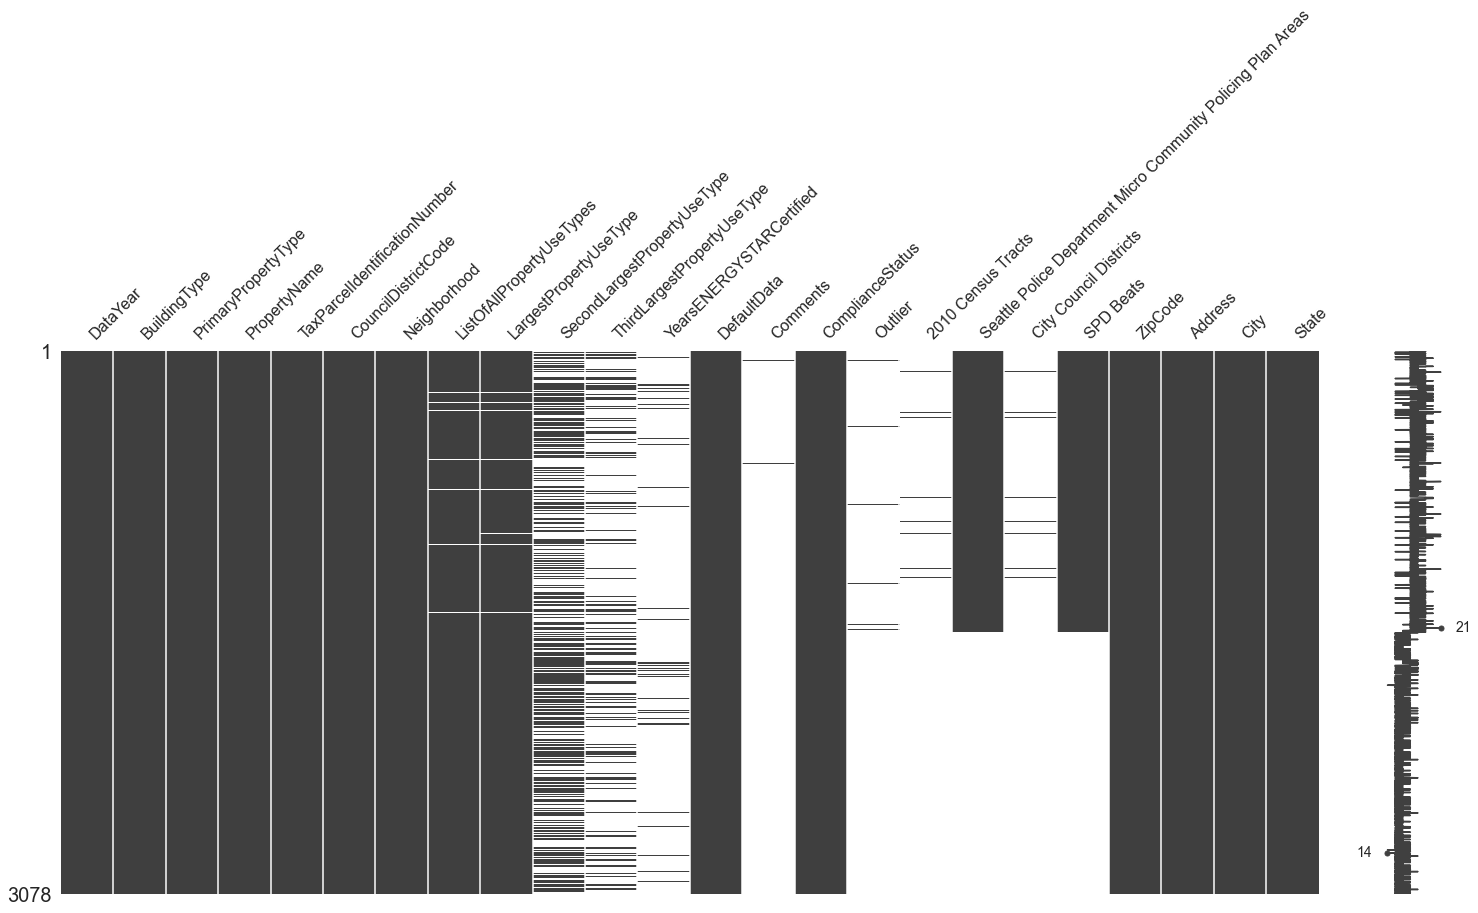

In [72]:
# import missingno as msno
msno.matrix(data_df.select_dtypes(exclude='number'))


<AxesSubplot:>

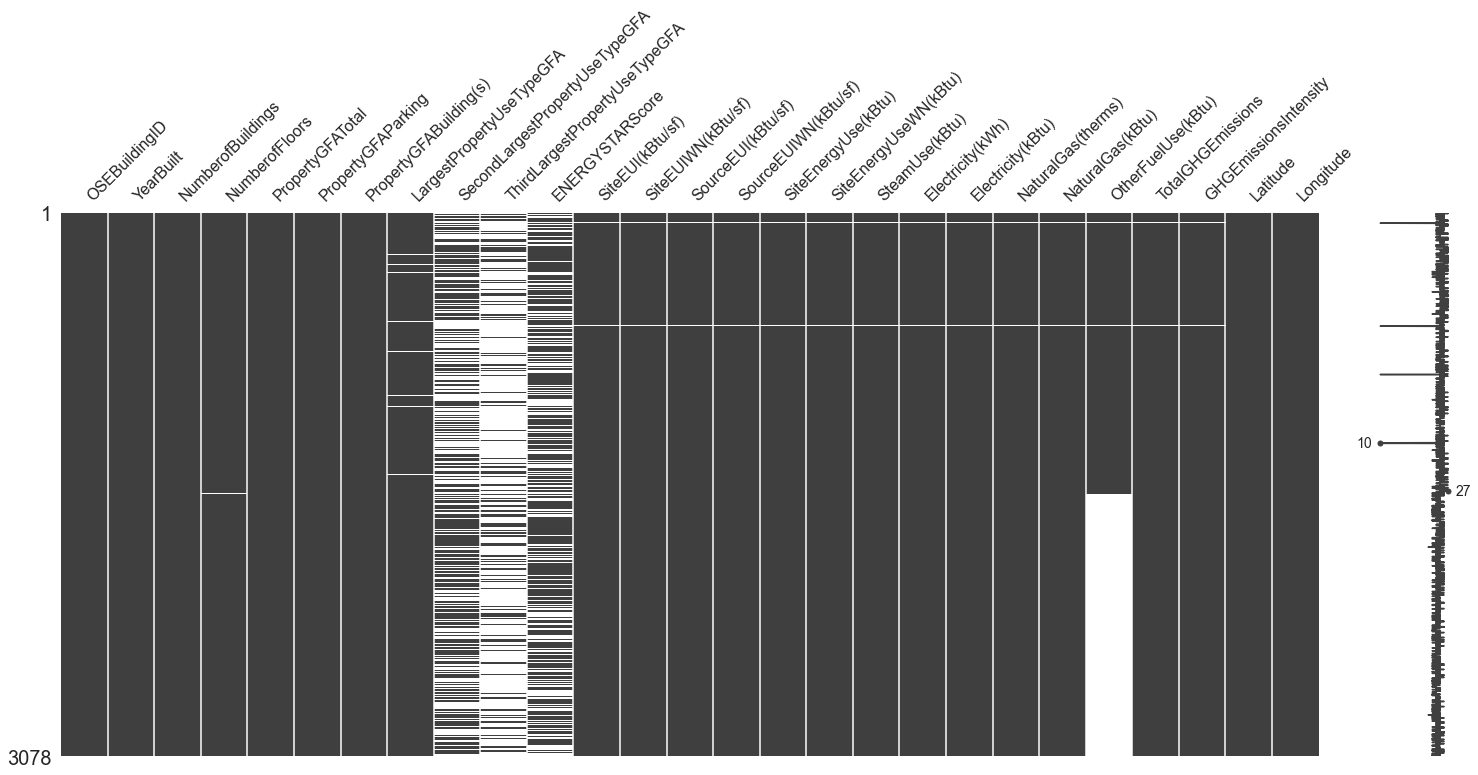

In [73]:
msno.matrix(data_df.select_dtypes(include='number'))


### 2.4.99 Pipeline de nettoyage


In [74]:
data2015 = import_donnees('data/raw/2015-building-energy-benchmarking.csv')
data2016 = import_donnees('data/raw/2016-building-energy-benchmarking.csv')

data_df2 = data_df.copy()

data_df = (data2015
           .pipe(renommer_cols)
           .pipe(split_location)
           .pipe(append_donnees_2016, data2016)
           .pipe(drop_buildings_one_data_measurement)
           .pipe(corriger_datatypes)
           .pipe(drop_lignes_sans_cible)
           .pipe(corriger_property_use_type)
           .pipe(drop_residential)
           .pipe(drop_non_compliant)
           .pipe(drop_outliers_variation_consommation)
           )


bâtiments en commun 3284
drop_lignes_sans_cible: ['GHGEmissionsIntensity', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
éliminer outliers variation_consommation :Int64Index([   58,   355,   543,   580,   765,   803, 20402, 20871, 21119,
            23701, 23730, 23835, 24102, 24205, 24531, 26710, 26849, 27184,
            27381, 27668, 28033, 34348, 49940],
           dtype='int64', name='OSEBuildingID')


# 3. Analyse Exploratoire


In [75]:
data_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3078 entries, 0 to 3077
Columns: 51 entries, OSEBuildingID to State
dtypes: float64(22), int64(5), object(24)
memory usage: 1.2+ MB


## 3.1 Données numériques


In [76]:
data_df.select_dtypes(include='number').columns


Index(['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'Latitude', 'Longitude'],
      dtype='object')

In [77]:
data_df.select_dtypes('number').describe()


,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude
count,3078.000000,3078.000000,3078.000000,3070.000000,3.078000e+03,3078.000000,3.078000e+03,3.020000e+03,1601.000000,655.000000,2049.000000,3072.000000,3071.000000,3072.000000,3072.000000,3.072000e+03,3.071000e+03,3.072000e+03,3.072000e+03,3.072000e+03,3.072000e+03,3.072000e+03,1.591000e+03,3072.000000,3072.000000,3078.000000,3078.000000
mean,15565.876218,1961.405458,1.087394,4.201629,1.139929e+05,13684.291423,1.003086e+05,9.247085e+04,35461.000810,13650.670532,63.767692,72.481445,75.867698,178.307422,181.787500,7.776550e+06,7.965886e+06,4.524559e+05,1.610121e+06,5.493848e+06,1.815106e+04,1.815106e+06,1.474710e+04,169.623398,1.476650,47.616257,-122.333458
std,12963.669263,32.636593,1.169081,6.672290,1.970003e+05,43918.490222,1.738159e+05,1.611341e+05,65087.905377,28359.609919,28.643582,70.629996,72.051491,176.642994,176.417709,1.886469e+07,1.913375e+07,4.943821e+06,3.851261e+06,1.314078e+07,6.030069e+04,6.030069e+06,2.837561e+05,567.429860,2.122747,0.047598,0.023977
min,1.000000,1900.000000,0.000000,0.000000,1.630000e+04,-2.000000,-5.055000e+04,5.656000e+03,0.000000,0.000000,1.000000,0.700000,0.000000,-2.000000,-2.100000,1.715000e+04,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,0.000000e+00,-0.800000,-0.020000,47.499331,-122.411820
25%,581.000000,1930.000000,1.000000,1.000000,2.943725e+04,0.000000,2.844175e+04,2.548075e+04,5444.000000,2733.500000,45.000000,33.800000,36.800000,78.400001,83.500000,1.244064e+06,1.357148e+06,0.000000e+00,2.166632e+05,7.392622e+05,0.000000e+00,0.000000e+00,0.000000e+00,19.920000,0.270000,47.586885,-122.343540
50%,21088.000000,1965.000000,1.000000,2.000000,4.892450e+04,0.000000,4.687900e+04,4.275500e+04,12208.000000,6000.000000,71.000000,52.700001,56.200000,135.450000,139.400002,2.615611e+06,2.778833e+06,0.000000e+00,4.926117e+05,1.680826e+06,4.761960e+03,4.761960e+05,0.000000e+00,49.280000,0.780000,47.612380,-122.333228
75%,24479.000000,1988.000000,1.000000,4.000000,1.047860e+05,0.000000,9.447000e+04,8.969900e+04,30700.000000,12941.000000,88.000000,83.599998,87.500000,210.124999,212.924995,7.152465e+06,7.399712e+06,0.000000e+00,1.488251e+06,5.078072e+06,1.482175e+04,1.482186e+06,0.000000e+00,139.530000,1.792500,47.648791,-122.322623
max,50038.000000,2014.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.349435e+08,8.344505e+07,2.847263e+08,1.381912e+06,1.381912e+08,8.269669e+06,12307.160000,31.380000,47.733870,-122.258795


### 3.1.1 Box plots des colonnes numériques


numeric_cols : ['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude']
"6-2_identification_outliers_par_boxplot.png"


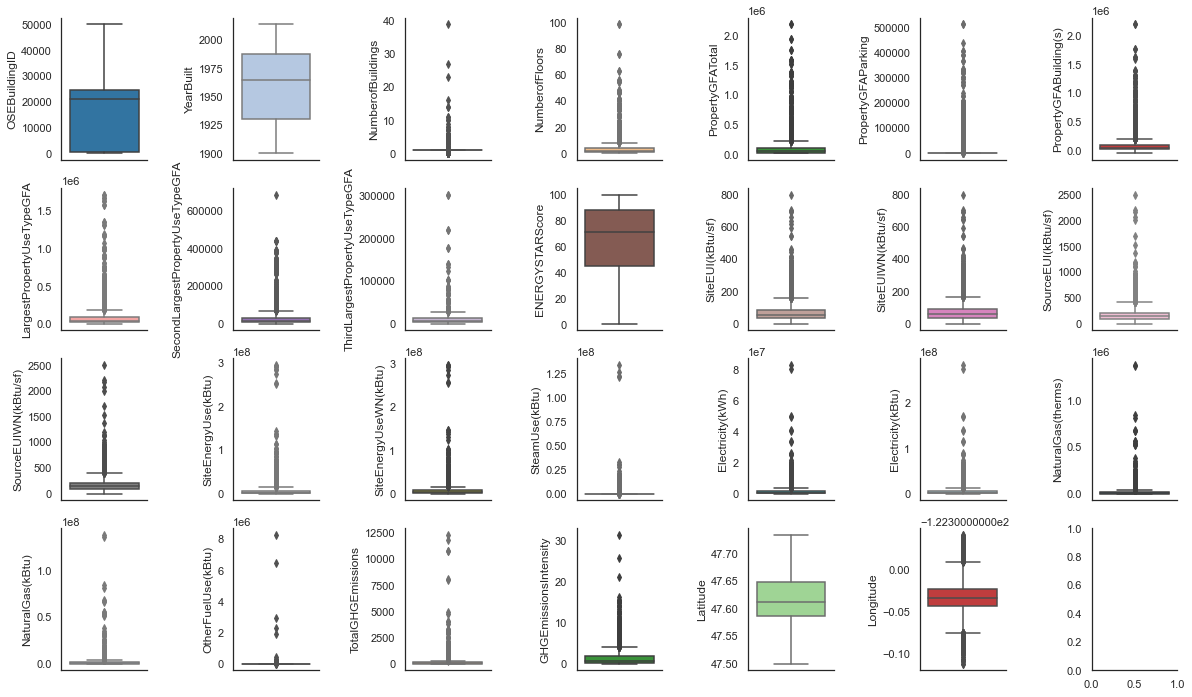

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_colonnes_as_box(df: pd.DataFrame):
    # mean and median in centre if normal
    numeric_cols = df.select_dtypes('number').columns.tolist()
    print(f'numeric_cols : {numeric_cols}')
    n_rows = 4
    n_cols = (len(numeric_cols) + 1) // n_rows
    colors = sns.color_palette("tab20").as_hex()[:len(numeric_cols) + 1]
    if len(colors) < len(numeric_cols):
        colors = colors + colors  # max 40 colonnes
    plt.subplots(figsize=(20, 12), ncols=n_cols, nrows=n_rows)
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=plt.subplot(
            n_rows, n_cols, i + 1), color=colors[i])
        sns.despine()
    # espace entre les plots
    plt.subplots_adjust(wspace=1, hspace=0.2)
    to_png(f'6.2_identification_outliers_par_boxplot')


data_df.pipe(plot_colonnes_as_box)
plt.show()


### 3.1.2 Distributions des colonnes numériques


numeric_cols : ['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude']
"6-3_distribution_colonnes_numériques_histogram.png"


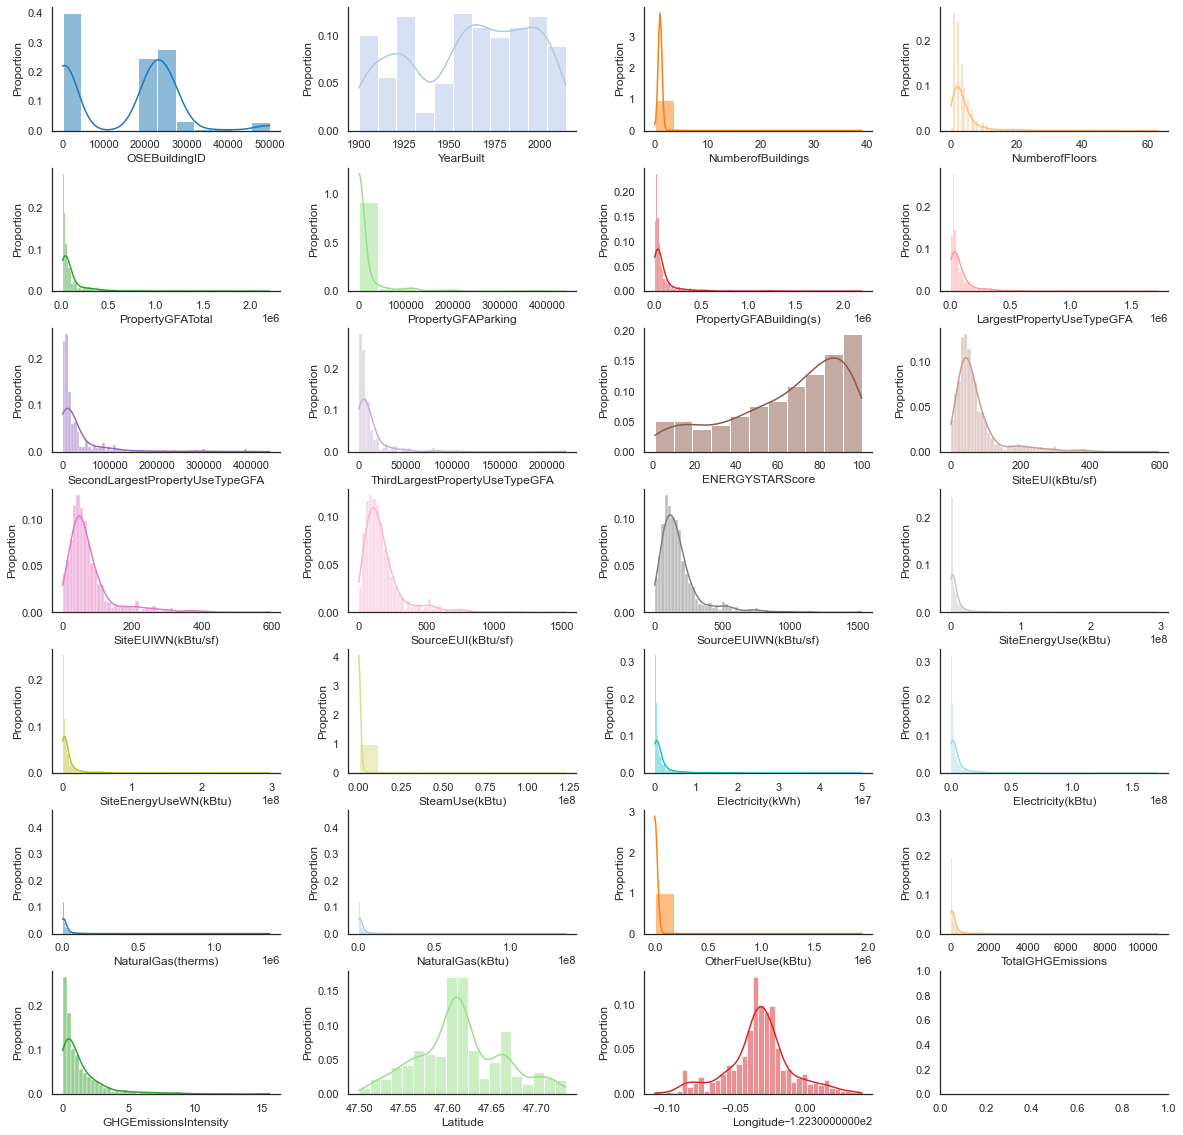

In [79]:
def plot_colonnes_as_histogram(df):
    numeric_cols = df.select_dtypes('number').columns.tolist()
    print(f'numeric_cols : {numeric_cols}')
    n_cols = 4
    n_rows = len(numeric_cols) // n_cols
    if (len(numeric_cols) % n_cols) > 0:
        n_rows += 1
    colors = sns.color_palette("tab20").as_hex()[:len(numeric_cols)]
    if len(colors) < len(numeric_cols):
        colors = colors + colors  # max 40 colonnes
    plt.subplots(figsize=(20, 20), ncols=n_cols, nrows=n_rows)
    sample_size = min(1000, len(df))
    dfs = df[numeric_cols].sample(sample_size)
    for i, col in enumerate(numeric_cols):
        ax1 = sns.histplot(dfs[col].dropna().astype(float), ax=plt.subplot(n_rows, n_cols, i + 1),
                           kde=True, stat='proportion', color=colors[i])
        # bins=40, kde=True, stat='proportion',color=colors[i])
        ax1.set_xlabel(col)
        sns.despine()

    # espace entre les plots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    to_png(f'6.3_distribution_colonnes_numériques_histogram')


data_df.pipe(plot_colonnes_as_histogram)


## 3.2 Données catégoriques


In [80]:
data_df.select_dtypes(exclude='number').columns


Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'YearsENERGYSTARCertified', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'ZipCode', 'Address', 'City',
       'State'],
      dtype='object')

### 3.2.1 Building Type


In [81]:
data_df['BuildingType'].value_counts()


NonResidential        2793
Nonresidential COS     134
SPS-District K-12      108
Campus                  43
Name: BuildingType, dtype: int64

### 3.2.2 Visualise le comptage / fréquence dans chaque catégorie


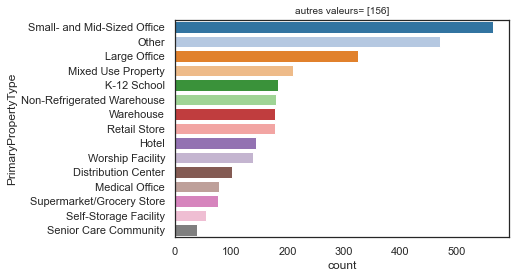

In [82]:
def plot_category_count(df, col, figsize=(6, 4), nb=15):
    plt.figure(figsize=figsize)
    counts = df[col].value_counts()
    nb = min(len(counts), nb)
    top_n = counts.index[:nb]
    others = 0 if nb == len(counts) else counts[nb:].sum()
    sns.countplot(y=df[df[col].isin(top_n)][col], order=top_n)
    if others > 0:
        plt.title(f'autres valeurs= [{others}]', fontsize=10)


data_df.pipe(plot_category_count, 'PrimaryPropertyType')


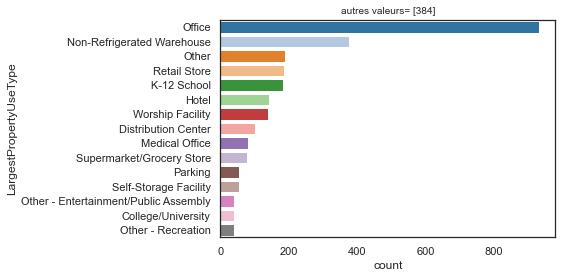

In [83]:
data_df.pipe(plot_category_count, 'LargestPropertyUseType')


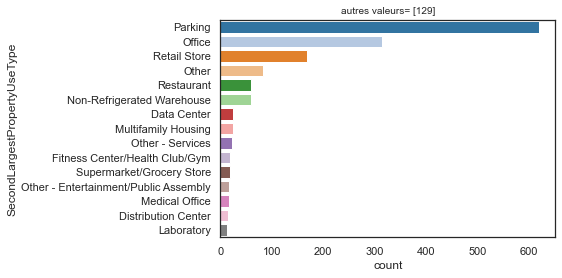

In [84]:
data_df.pipe(plot_category_count, 'SecondLargestPropertyUseType')


In [85]:
category_cols = data_df.select_dtypes(include='object').columns.tolist()
data_df[category_cols].nunique().sort_values()


State                                                               1
ComplianceStatus                                                    1
City Council Districts                                              2
Outlier                                                             2
City                                                                2
DataYear                                                            2
DefaultData                                                         3
BuildingType                                                        4
CouncilDistrictCode                                                 7
Comments                                                           11
2010 Census Tracts                                                 12
Neighborhood                                                       18
PrimaryPropertyType                                                25
ThirdLargestPropertyUseType                                        40
ZipCode             

## 3.4 Visualisation des distributions de consommation énergétique

On compare les distributions de "Energy Use Intensity divisé par surface du sol"


"Distribution_de_'SiteEUI(kBtu_sf)'_pour_2015_et_2016_(superposées).png"


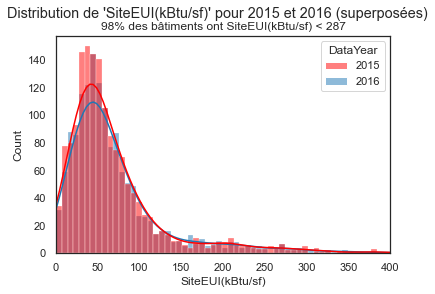

In [86]:
sns.histplot(data=data_df, x='SiteEUI(kBtu/sf)', hue='DataYear',
             palette=['#ff0000', '#1f77b4'], alpha=0.5, kde=True)
plt.suptitle(
    "Distribution de 'SiteEUI(kBtu/sf)' pour 2015 et 2016 (superposées)")
plt.title(
    f'98% des bâtiments ont SiteEUI(kBtu/sf) < {data_df["SiteEUI(kBtu/sf)"].quantile(0.98):.0f}')
plt.xlim((0, 400))
to_png()
plt.show()


## 3.4 Visualisation des distributions de consommation énergétique

On compare les distributions de "SiteEnergyUse(kBtu)"


"Distribution_de_'SiteEnergyUse(kBtu)'_pour_2015_et_2016_(superposées).png"


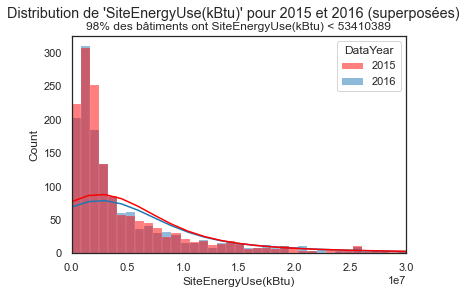

In [87]:
sns.histplot(data=data_df, x='SiteEnergyUse(kBtu)', hue='DataYear',
             palette=['#ff0000', '#1f77b4'], alpha=0.5, kde=True)
plt.suptitle(
    "Distribution de 'SiteEnergyUse(kBtu)' pour 2015 et 2016 (superposées)")
plt.title(
    f'98% des bâtiments ont SiteEnergyUse(kBtu) < {data_df["SiteEnergyUse(kBtu)"].quantile(0.98):.0f}')
plt.xlim((0, 30 * 1000 * 1000))
to_png()
plt.show()


## 3.5 Visualisation des distributions des émissions CO2


"Distribution_de_'TotalGHGEmissions'_pour_2015_et_2016_(superposées).png"


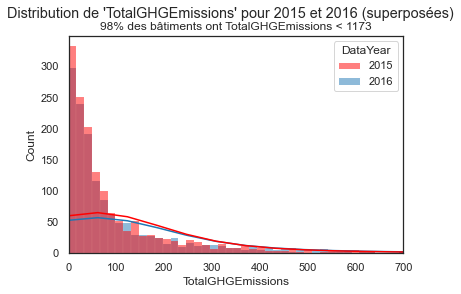

In [88]:
sns.histplot(data=data_df, x='TotalGHGEmissions', hue='DataYear',
             palette=['#ff0000', '#1f77b4'], alpha=0.5, kde=True)
plt.suptitle(
    "Distribution de 'TotalGHGEmissions' pour 2015 et 2016 (superposées)")
plt.title(
    f'98% des bâtiments ont TotalGHGEmissions < {data_df["TotalGHGEmissions"].quantile(0.98):.0f}')
plt.xlim((0, 700))
to_png()
plt.show()


## 3.6 Visualisation des distributions de ENERGYSTARScore


"Distribution_de_l'ENERGYSTARScore'_pour_2015_et_2016_(superposées).png"


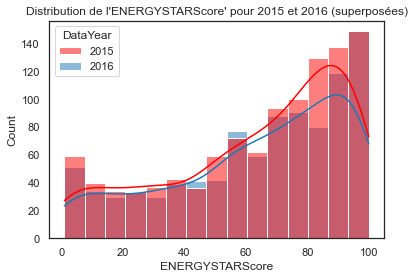

In [89]:
sns.histplot(data=data_df, x='ENERGYSTARScore', hue='DataYear',
             palette=['#ff0000', '#1f77b4'], alpha=0.5, kde=True)
plt.title("Distribution de l'ENERGYSTARScore' pour 2015 et 2016 (superposées)")
to_png()


# 4. Feature Engineering


# 5. Enregistre les données nettoyées


In [90]:
data_df.to_csv('data/out/cleaned_data.csv', encoding='utf-8', index=False)
